In [1]:
# Before starting this notebook
#cd ..

In [26]:
import base64

# Local 
from image_net_labels import MAPPING

# 3rd Party 
from PIL import Image
import requests
from io import BytesIO
from baybars.timber import get_logger
import requests

In [27]:
# asyncs are removed due to https://github.com/jupyter/notebook/issues/3397

In [28]:
logger = get_logger('resnet_client')

# The server URL specifies the endpoint of your server running the ResNet
# model with the name "resnet" and using the predict interface.
RESNET_STATUS_URL = 'http://localhost:8501/v1/models/resnet'
SERVER_URL = 'http://localhost:8501/v1/models/resnet:predict'

# The image URL is the location of the image we should send to the server
IMAGE_URL = 'https://tensorflow.org/images/blogs/serving/cat.jpg'


def get_as_base64(image_url):
  out = None
  response = requests.get(image_url)
  if response.status_code == 200:
    out = base64.b64encode(response.content) 

  return out 

In [29]:
def main():
  out = []
  response = requests.get(RESNET_STATUS_URL)
  logger.info('resnet status: {}'.format(response.json()))
  image_content = get_as_base64(IMAGE_URL)
  predict_request = {
    'instances': [{'b64': image_content.decode()}],
  }

  # Send few requests to warm-up the model.
  for _ in range(3):
    response = requests.post(SERVER_URL, json=predict_request)
    response.raise_for_status()

  # Send few actual requests and report average latency
  total_time = 0
  num_requests = 100
  for _ in range(num_requests):
    response = requests.post(SERVER_URL, json=predict_request)
    response.raise_for_status()
    total_time += response.elapsed.total_seconds()
    prediction = response.json()['predictions'][0]
    out.append(prediction)

  logger.info('Prediction class: {}, avg latency: {} ms'.format(
      prediction['classes'], (total_time*1000)/num_requests))

  return out

In [30]:
predictions = main()

[baybars][resnet_client][2019-01-11 10:05:48,209][INFO]:resnet status: {'model_version_status': [{'version': '1538687457', 'state': 'AVAILABLE', 'status': {'error_code': 'OK', 'error_message': ''}}]}
[baybars][resnet_client][2019-01-11 10:05:48,209][INFO]:resnet status: {'model_version_status': [{'version': '1538687457', 'state': 'AVAILABLE', 'status': {'error_code': 'OK', 'error_message': ''}}]}
[baybars][resnet_client][2019-01-11 10:05:48,209][INFO]:resnet status: {'model_version_status': [{'version': '1538687457', 'state': 'AVAILABLE', 'status': {'error_code': 'OK', 'error_message': ''}}]}
[baybars][resnet_client][2019-01-11 10:06:02,149][INFO]:Prediction class: 286, avg latency: 126.77062 ms
[baybars][resnet_client][2019-01-11 10:06:02,149][INFO]:Prediction class: 286, avg latency: 126.77062 ms
[baybars][resnet_client][2019-01-11 10:06:02,149][INFO]:Prediction class: 286, avg latency: 126.77062 ms


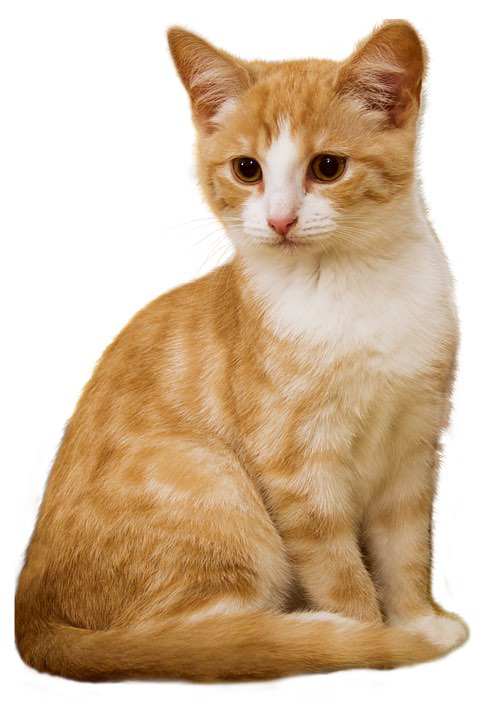

In [31]:
response = requests.get(IMAGE_URL)
Image.open(BytesIO(response.content))

In [32]:
MAPPING[predictions[0]['classes']]

'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor'